Maastricht_University_logo.svg

# Information Retrieval and Text Mining Course
## Tutorial 08 — Detecting Patterns and Organizing Text: Supervised Text Classification (Part 1)

**Author:** Jan Scholtes

**Edition 2025-2026**

Department of Advanced Computer Sciences — Maastricht University

Welcome to Tutorial 08 on **Supervised Text Classification**. Text classification is a fundamental task in Information Retrieval and Text Mining: by transforming unstructured text into structured categories, we enable machines to understand intent, prioritize risk, and orchestrate complex tasks.

In this tutorial, you will learn and practice several supervised methods for document classification:

1. **Decision Trees and Random Forests** — entropy-based splitting and ensemble learning.
2. **Naïve Bayes Classifier** — probabilistic classification using Bayes' rule.
3. **Logistic Regression** — discriminative classification with gradient descent.
4. **k-Nearest Neighbors (kNN)** — instance-based lazy learning.
5. **Support Vector Machines (SVM)** — maximum-margin classification with linear and non-linear kernels.
6. **Fine-tuning BERT for Sentiment Analysis** — deep learning approach with Transformers.
7. **Sentiment and Emotion Analysis** — keyword-based vs. BERT-based approaches.
8. **Toxic Text Detection** — content moderation with classification.

At the end you will find the **Exercises** section with graded assignments.

> **Note:** This course is about Information Retrieval, Text Mining, and Conversational Search — not about programming skills. The code cells below show you *how* these methods work in practice using Python libraries. Focus on understanding the **concepts** and **results**.

## Library Installation

We install all required packages in a single cell. Run this cell once at the beginning of your session.

In [1]:
# Install required packages
import subprocess, sys

packages = [
    "scikit-learn",
    "datasets",
    "transformers",
    "accelerate",
    "nltk",
    "matplotlib",
    "seaborn",
    "wordcloud",
]
for pkg in packages:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

print("All packages installed successfully.")

All packages installed successfully.


## Library Imports

All imports are grouped here so the notebook is easy to set up and run.

In [2]:
# Standard library
import os
import random
import warnings
from collections import Counter
from pprint import pprint

# Data & visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLTK
import nltk
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('movie_reviews', quiet=True)
nltk.download('vader_lexicon', quiet=True)
from nltk.corpus import movie_reviews, stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
)
from sklearn.pipeline import Pipeline

# PyTorch
import torch

# HuggingFace Transformers
from transformers import (
    BertTokenizerFast,
    BertForSequenceClassification,
    Trainer, TrainingArguments,
)
from datasets import load_dataset

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print("All libraries loaded successfully.")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

c:\Users\jcsch\OneDrive - Dennenhof Capital BV\Documents\UM\IRTM\IRTM 2025-2026\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All libraries loaded successfully.
PyTorch version: 2.6.0+cu124
CUDA available: True


---
# Dataset: The 20 Newsgroups Corpus

Throughout this tutorial we will use the **20 Newsgroups** dataset, a classic benchmark for text classification. It contains approximately 20,000 newsgroup postings across 20 different topics.

For the first five sections we select a 4-category subset to keep training times short. We also prepare the NLTK Movie Reviews corpus for sentiment analysis.

In [3]:
# Load 20 Newsgroups (4 categories for speed)
from sklearn.datasets import fetch_20newsgroups

categories = ['sci.space', 'rec.sport.hockey', 'comp.graphics', 'talk.politics.mideast']

newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=('headers','footers','quotes'), random_state=SEED)
newsgroups_test  = fetch_20newsgroups(subset='test',  categories=categories, remove=('headers','footers','quotes'), random_state=SEED)

print(f"Training documents: {len(newsgroups_train.data)}")
print(f"Test documents:     {len(newsgroups_test.data)}")
print(f"Categories:         {newsgroups_train.target_names}")
print(f"\nSample document (first 200 chars):\n{newsgroups_train.data[0][:200]}...")

Training documents: 2341
Test documents:     1558
Categories:         ['comp.graphics', 'rec.sport.hockey', 'sci.space', 'talk.politics.mideast']

Sample document (first 200 chars):
: 8~> I require BGI drivers for Super VGA Displays and Super XVGA Displays. Does 
: 8~> anyone know where I could obtain the relevant drivers ? (FTP sites ??)

: 	I would like to know too!

: Regards,...


In [6]:
# Create TF-IDF features (used by most classifiers)
tfidf = TfidfVectorizer(max_features=10000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(newsgroups_train.data)
X_test_tfidf  = tfidf.transform(newsgroups_test.data)

y_train = newsgroups_train.target
y_test  = newsgroups_test.target

print(f"TF-IDF matrix shape: {X_train_tfidf.shape} (documents × features)")

TF-IDF matrix shape: (2341, 10000) (documents × features)


We also create a **CountVectorizer** (for Naïve Bayes, which works with raw counts) and store the target names for label display.

In [7]:
# Count features for Naive Bayes
count_vec = CountVectorizer(max_features=10000, stop_words='english')
X_train_counts = count_vec.fit_transform(newsgroups_train.data)
X_test_counts  = count_vec.transform(newsgroups_test.data)

target_names = newsgroups_train.target_names

# Helper function to print evaluation results
def evaluate_classifier(name, y_true, y_pred, target_names):
    print(f"\n{'='*60}")
    print(f"  {name}")
    print(f"{'='*60}")
    print(classification_report(y_true, y_pred, target_names=target_names))
    return accuracy_score(y_true, y_pred)

---
# 1. Decision Trees and Random Forests

## 1.1 Decision Trees

A **decision tree** classifies documents by learning a hierarchy of if-then rules from the training data. At each internal node, the algorithm selects the feature (word) that best splits the data, measured by **information gain** (reduction in entropy).

**Entropy** measures the impurity of a dataset:

$$H(S) = -\sum_{i=1}^{c} p_i \log_2 p_i$$

where $p_i$ is the proportion of samples belonging to class $i$. A set that is 100% one class has entropy 0 (pure); a 50-50 split has entropy 1 (maximum impurity).

**Information gain** is the reduction in entropy achieved by splitting on a particular feature:

$$IG(S, A) = H(S) - \sum_{v \in \text{values}(A)} \frac{|S_v|}{|S|} H(S_v)$$

The algorithm recursively picks the attribute with the highest information gain as the splitting node.

In [8]:
# Train a Decision Tree classifier
dt_clf = DecisionTreeClassifier(max_depth=20, random_state=SEED)
dt_clf.fit(X_train_tfidf, y_train)

y_pred_dt = dt_clf.predict(X_test_tfidf)
acc_dt = evaluate_classifier("Decision Tree", y_test, y_pred_dt, target_names)


  Decision Tree
                       precision    recall  f1-score   support

        comp.graphics       0.88      0.51      0.64       389
     rec.sport.hockey       0.92      0.68      0.78       399
            sci.space       0.46      0.89      0.61       394
talk.politics.mideast       0.84      0.61      0.70       376

             accuracy                           0.67      1558
            macro avg       0.77      0.67      0.68      1558
         weighted avg       0.77      0.67      0.68      1558



In [9]:
# Visualize the top of the decision tree
tree_text = export_text(dt_clf, feature_names=tfidf.get_feature_names_out().tolist(), max_depth=3)
print("Decision Tree (first 3 levels):\n")
print(tree_text)

Decision Tree (first 3 levels):

|--- space <= 0.02
|   |--- team <= 0.00
|   |   |--- israel <= 0.00
|   |   |   |--- graphics <= 0.00
|   |   |   |   |--- truncated branch of depth 17
|   |   |   |--- graphics >  0.00
|   |   |   |   |--- class: 0
|   |   |--- israel >  0.00
|   |   |   |--- class: 3
|   |--- team >  0.00
|   |   |--- israeli <= 0.05
|   |   |   |--- software <= 0.02
|   |   |   |   |--- truncated branch of depth 4
|   |   |   |--- software >  0.02
|   |   |   |   |--- truncated branch of depth 2
|   |   |--- israeli >  0.05
|   |   |   |--- class: 3
|--- space >  0.02
|   |--- color <= 0.04
|   |   |--- armenia <= 0.06
|   |   |   |--- ames <= 0.13
|   |   |   |   |--- truncated branch of depth 6
|   |   |   |--- ames >  0.13
|   |   |   |   |--- truncated branch of depth 2
|   |   |--- armenia >  0.06
|   |   |   |--- class: 3
|   |--- color >  0.04
|   |   |--- 30 <= 0.02
|   |   |   |--- class: 0
|   |   |--- 30 >  0.02
|   |   |   |--- class: 2



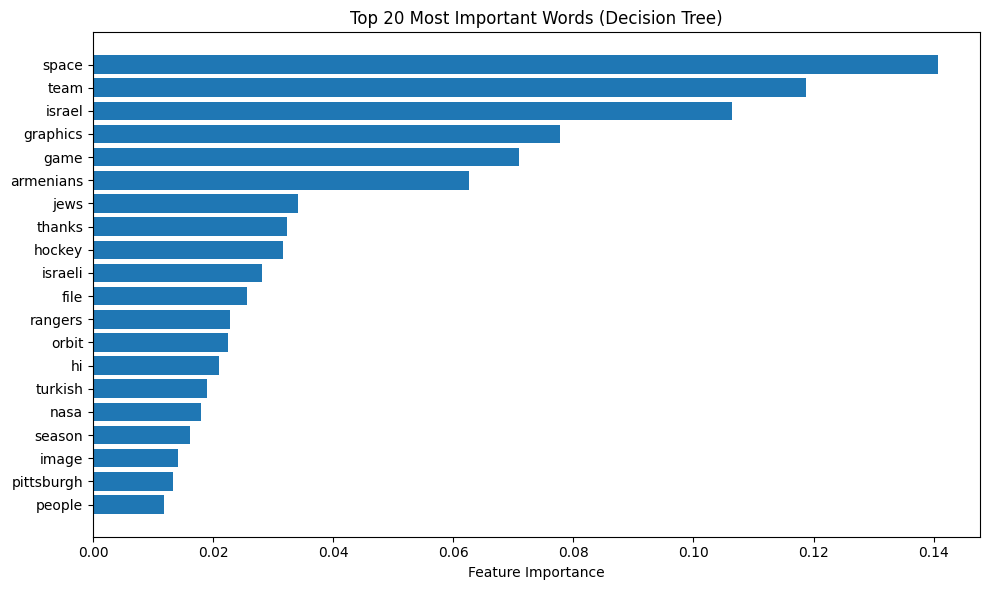

In [10]:
# Feature importances: which words are most discriminating?
importances = dt_clf.feature_importances_
feature_names = tfidf.get_feature_names_out()
top_k = 20
top_indices = np.argsort(importances)[-top_k:]

plt.figure(figsize=(10, 6))
plt.barh(range(top_k), importances[top_indices])
plt.yticks(range(top_k), feature_names[top_indices])
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Words (Decision Tree)')
plt.tight_layout()
plt.show()

## 1.2 Random Forests

A **Random Forest** is an *ensemble* of decision trees. Each tree is trained on a random subset of the data (bagging) and uses a random subset of features. The final prediction is the majority vote across all trees — the "wisdom of crowds."

Key advantages:
- **Reduces overfitting** compared to a single decision tree
- **Low correlation** between trees (due to random feature selection) increases ensemble diversity
- **More robust** to noise and outliers

In [11]:
# Train a Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=SEED, n_jobs=-1)
rf_clf.fit(X_train_tfidf, y_train)

y_pred_rf = rf_clf.predict(X_test_tfidf)
acc_rf = evaluate_classifier("Random Forest (100 trees)", y_test, y_pred_rf, target_names)


  Random Forest (100 trees)
                       precision    recall  f1-score   support

        comp.graphics       0.89      0.84      0.86       389
     rec.sport.hockey       0.97      0.85      0.90       399
            sci.space       0.66      0.90      0.76       394
talk.politics.mideast       0.98      0.78      0.87       376

             accuracy                           0.84      1558
            macro avg       0.87      0.84      0.85      1558
         weighted avg       0.87      0.84      0.85      1558



---
# 2. Naïve Bayes Classifier

**Naïve Bayes** is a probabilistic classifier based on Bayes' theorem with a strong (naïve) independence assumption between features. Given a document $d$ and a class $c$:

$$c_{\text{MAP}} = \arg\max_{c \in C} P(c \mid d) = \arg\max_{c \in C} P(d \mid c) \cdot P(c)$$

Under the **Naïve Bayes assumption**, the probability of observing a document given a class is the product of individual word probabilities:

$$P(d \mid c) = \prod_{i=1}^{n} P(x_i \mid c)$$

**Key properties:**
- **Training**: simply count word frequencies per class (very fast — $O(|D| \cdot L_{\text{avg}})$)
- **Classification**: compute log-probabilities for each class and pick the highest ($O(|C| \cdot L_t)$)
- **Laplace smoothing** prevents zero probabilities for unseen words: $P(x_i \mid c_j) = \frac{N(x_i, c_j) + 1}{N(c_j) + |V|}$
- Simple weight interpretation: $\log P(x_i \mid c)$ tells you how indicative word $x_i$ is of class $c$

Despite violating the independence assumption (words in natural language are not independent), Naïve Bayes performs surprisingly well for text classification and is often used as a fast baseline.

In [12]:
# Train a Multinomial Naive Bayes classifier (uses word counts, not TF-IDF)
nb_clf = MultinomialNB(alpha=1.0)  # alpha=1.0 is Laplace smoothing
nb_clf.fit(X_train_counts, y_train)

y_pred_nb = nb_clf.predict(X_test_counts)
acc_nb = evaluate_classifier("Naive Bayes (Multinomial)", y_test, y_pred_nb, target_names)


  Naive Bayes (Multinomial)
                       precision    recall  f1-score   support

        comp.graphics       0.92      0.91      0.91       389
     rec.sport.hockey       0.91      0.92      0.92       399
            sci.space       0.90      0.83      0.87       394
talk.politics.mideast       0.88      0.95      0.91       376

             accuracy                           0.90      1558
            macro avg       0.90      0.90      0.90      1558
         weighted avg       0.90      0.90      0.90      1558



In [13]:
# Show the most informative features per class
print("Most informative words per class (highest log-probability):\n")
for i, category in enumerate(target_names):
    log_probs = nb_clf.feature_log_prob_[i]
    top_indices = np.argsort(log_probs)[-10:][::-1]
    words = count_vec.get_feature_names_out()[top_indices]
    print(f"  {category:30s}: {', '.join(words)}")

Most informative words per class (highest log-probability):

  comp.graphics                 : image, graphics, edu, jpeg, file, use, data, files, images, software
  rec.sport.hockey              : team, game, 10, hockey, 25, play, 55, season, 11, 12
  sci.space                     : space, nasa, launch, earth, like, data, orbit, time, shuttle, just
  talk.politics.mideast         : people, armenian, armenians, said, israel, turkish, jews, know, israeli, don


---
# 3. Logistic Regression

**Logistic Regression** is a *discriminative* classifier (unlike the *generative* Naïve Bayes). It directly models $P(c \mid d)$ by learning a weight vector $\mathbf{w}$ and bias $b$:

$$z = \mathbf{w} \cdot \mathbf{x} + b$$
$$P(y=1 \mid \mathbf{x}) = \sigma(z) = \frac{1}{1 + e^{-z}}$$

**Generative vs. Discriminative:**
- *Naïve Bayes* (generative): "Given class $c$, what does a typical document look like?"
- *Logistic Regression* (discriminative): "What features distinguish class $c$ from others?"

**Training** uses **cross-entropy loss** minimized by **stochastic gradient descent (SGD)**. The gradient update is remarkably simple:

$$\mathbf{w} \leftarrow \mathbf{w} - \eta \cdot (\hat{y} - y) \cdot \mathbf{x}$$

**Properties:**
- Computationally efficient and highly interpretable
- Linear decision boundary (same as Naïve Bayes, but usually better calibrated)
- Requires feature selection — sensitive to irrelevant features
- Cannot solve non-linear problems (unlike SVM with kernels)

In [14]:
# Train a Logistic Regression classifier
lr_clf = LogisticRegression(max_iter=1000, random_state=SEED, C=1.0)
lr_clf.fit(X_train_tfidf, y_train)

y_pred_lr = lr_clf.predict(X_test_tfidf)
acc_lr = evaluate_classifier("Logistic Regression", y_test, y_pred_lr, target_names)


  Logistic Regression
                       precision    recall  f1-score   support

        comp.graphics       0.92      0.90      0.91       389
     rec.sport.hockey       0.97      0.92      0.94       399
            sci.space       0.83      0.91      0.87       394
talk.politics.mideast       0.94      0.93      0.93       376

             accuracy                           0.91      1558
            macro avg       0.92      0.91      0.91      1558
         weighted avg       0.92      0.91      0.91      1558



In [15]:
# Show the most discriminative words per class (highest positive weights)
print("Most discriminative words per class (Logistic Regression):\n")
for i, category in enumerate(target_names):
    top_indices = np.argsort(lr_clf.coef_[i])[-10:][::-1]
    words = tfidf.get_feature_names_out()[top_indices]
    print(f"  {category:30s}: {', '.join(words)}")

Most discriminative words per class (Logistic Regression):

  comp.graphics                 : graphics, image, file, 3d, hi, computer, files, looking, thanks, code
  rec.sport.hockey              : hockey, game, team, games, season, play, nhl, players, mask, teams
  sci.space                     : space, nasa, orbit, moon, launch, spacecraft, earth, shuttle, lunar, solar
  talk.politics.mideast         : israel, israeli, jews, people, turkish, armenians, arab, jewish, armenian, mr


---
# 4. k-Nearest Neighbors (kNN)

**kNN** is a non-parametric, instance-based classifier. Instead of learning a model, it memorizes all training examples and classifies new documents by finding the $k$ most similar training documents and returning the majority class.

$$c_{\text{kNN}} = \arg\max_{c \in C} \sum_{d_i \in N_k(d)} \mathbf{1}[c(d_i) = c]$$

**Key properties:**
- **No training required** (lazy learning) — all computation happens at test time
- **Similarity metric**: for text, cosine similarity of TF-IDF vectors is most effective
- **k** is typically odd (3 or 5) to avoid ties
- **Cover & Hart (1967)**: asymptotic error rate of 1-NN is less than twice the Bayes optimal rate
- **Locally defined** decision boundaries — far-away points do not influence classification
- Scales well with many classes (no need to train separate classifiers)
- Can be expensive at test time for large datasets

In [16]:
# Train a kNN classifier
knn_clf = KNeighborsClassifier(n_neighbors=5, metric='cosine', n_jobs=-1)
knn_clf.fit(X_train_tfidf, y_train)

y_pred_knn = knn_clf.predict(X_test_tfidf)
acc_knn = evaluate_classifier("k-Nearest Neighbors (k=5)", y_test, y_pred_knn, target_names)


  k-Nearest Neighbors (k=5)
                       precision    recall  f1-score   support

        comp.graphics       0.83      0.90      0.86       389
     rec.sport.hockey       0.87      0.92      0.89       399
            sci.space       0.82      0.77      0.80       394
talk.politics.mideast       0.93      0.84      0.88       376

             accuracy                           0.86      1558
            macro avg       0.86      0.86      0.86      1558
         weighted avg       0.86      0.86      0.86      1558



---
# 5. Support Vector Machines (SVM)

**Support Vector Machines** find the hyperplane that maximizes the *margin* — the distance between the decision boundary and the nearest training points (the *support vectors*).

**Linear SVM** finds $\mathbf{w}$ and $b$ such that:
$$\min_{\mathbf{w},b} \frac{1}{2} \|\mathbf{w}\|^2 \quad \text{subject to} \quad y_i(\mathbf{w}^T \mathbf{x}_i + b) \geq 1 \quad \forall i$$

The margin is $\rho = \frac{2}{\|\mathbf{w}\|}$, and maximizing it is equivalent to minimizing $\|\mathbf{w}\|^2$.

**Why SVM works well for text:**
- TF-IDF vectors are very high-dimensional and sparse → linear separability is common
- The maximum-margin principle provides good generalization
- Only support vectors matter; the classifier is robust to the bulk of training data

**Non-linear SVM:** When data is not linearly separable, we can map features to a higher-dimensional space using a *kernel function* (e.g., polynomial, Gaussian/RBF). With dense word embeddings (Word2Vec, BERT), Gaussian SVM often outperforms linear SVM.

**Class imbalance:** SVM can be biased toward the majority class. Solutions include:
- **Under/over sampling** the training data
- **Ensemble methods** (split majority class into balanced subsets)
- **Cost-sensitive learning** (higher misclassification cost for minority class)

In [17]:
# Linear SVM (best for sparse TF-IDF features)
lsvm_clf = LinearSVC(C=1.0, random_state=SEED, max_iter=10000)
lsvm_clf.fit(X_train_tfidf, y_train)

y_pred_lsvm = lsvm_clf.predict(X_test_tfidf)
acc_lsvm = evaluate_classifier("Linear SVM", y_test, y_pred_lsvm, target_names)


  Linear SVM
                       precision    recall  f1-score   support

        comp.graphics       0.91      0.90      0.91       389
     rec.sport.hockey       0.94      0.92      0.93       399
            sci.space       0.84      0.89      0.86       394
talk.politics.mideast       0.94      0.92      0.93       376

             accuracy                           0.91      1558
            macro avg       0.91      0.91      0.91      1558
         weighted avg       0.91      0.91      0.91      1558



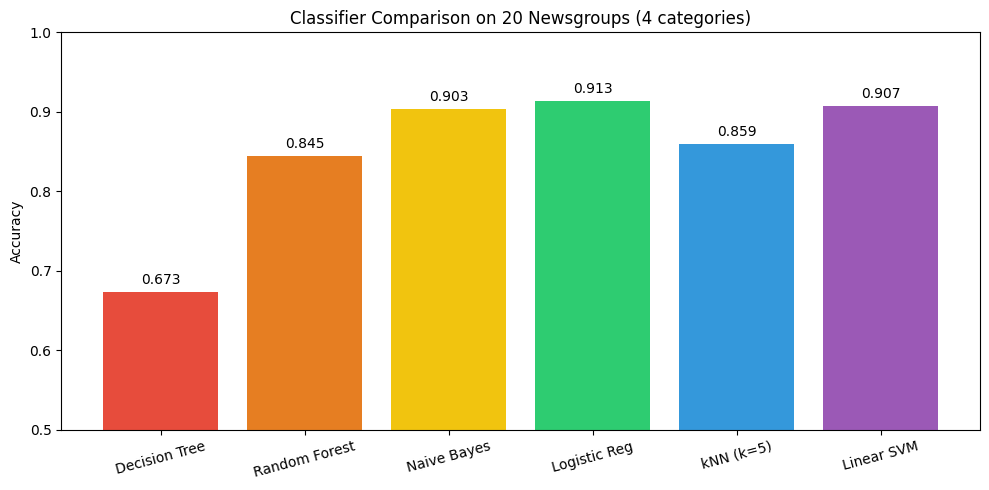

In [18]:
# Compare all classifiers so far
results = {
    'Decision Tree': acc_dt,
    'Random Forest':  acc_rf,
    'Naive Bayes':    acc_nb,
    'Logistic Reg':   acc_lr,
    'kNN (k=5)':      acc_knn,
    'Linear SVM':     acc_lsvm,
}

plt.figure(figsize=(10, 5))
bars = plt.bar(results.keys(), results.values(), color=['#e74c3c','#e67e22','#f1c40f','#2ecc71','#3498db','#9b59b6'])
plt.ylabel('Accuracy')
plt.title('Classifier Comparison on 20 Newsgroups (4 categories)')
plt.ylim(0.5, 1.0)
for bar, acc in zip(bars, results.values()):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{acc:.3f}', ha='center', fontsize=10)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

**Observation:** For text classification with TF-IDF features, **Linear SVM** and **Logistic Regression** typically perform best because TF-IDF features are high-dimensional and sparse, making linear separation effective. Naïve Bayes provides a fast, competitive baseline. Decision Trees tend to overfit without careful tuning.

---
# 6. Fine-tuning BERT for Sentiment Analysis

While traditional classifiers work well with handcrafted TF-IDF features, **BERT** (Bidirectional Encoder Representations from Transformers) can learn richer, context-sensitive representations. For **sentiment classification**, we use `BertForSequenceClassification`: the `[CLS]` token embedding is passed through a classification head, and the entire model is fine-tuned end-to-end.

**Key advantages of Transformers for text classification:**
- **Contextualized embeddings**: the meaning of a word depends on surrounding context
- **Transfer learning**: pre-trained on massive text corpora, only needs fine-tuning on task-specific data
- **No manual feature engineering**: no need for TF-IDF, stop word removal, or feature selection

**Trade-offs:**
- Requires a GPU for practical training times
- Much larger model (~110M parameters for BERT-base vs. a few thousand for SVM)
- Needs annotated training data for fine-tuning

We fine-tune BERT on the **IMDB movie review dataset** for binary sentiment classification (positive vs. negative).

In [19]:
# Load the IMDB dataset and create a balanced random subset for fast training
full_train = load_dataset("imdb", split="train")
full_test  = load_dataset("imdb", split="test")

# Shuffle with a fixed seed to randomize label order (IMDB stores neg first, then pos)
full_train = full_train.shuffle(seed=SEED)
full_test  = full_test.shuffle(seed=SEED)

# Take a stratified subset: 1500 positive + 1500 negative = 3000 training samples
# This ensures balanced classes and trains in ~2-4 minutes on an RTX 4070 GPU
TRAIN_SIZE_PER_CLASS = 1500
TEST_SIZE_PER_CLASS  = 500

pos_train = full_train.filter(lambda x: x['label'] == 1).select(range(TRAIN_SIZE_PER_CLASS))
neg_train = full_train.filter(lambda x: x['label'] == 0).select(range(TRAIN_SIZE_PER_CLASS))
from datasets import concatenate_datasets
train_set = concatenate_datasets([pos_train, neg_train]).shuffle(seed=SEED)

pos_test = full_test.filter(lambda x: x['label'] == 1).select(range(TEST_SIZE_PER_CLASS))
neg_test = full_test.filter(lambda x: x['label'] == 0).select(range(TEST_SIZE_PER_CLASS))
test_set = concatenate_datasets([pos_test, neg_test]).shuffle(seed=SEED)

print(f"Training set: {len(train_set)} examples  (pos: {sum(1 for x in train_set if x['label']==1)}, neg: {sum(1 for x in train_set if x['label']==0)})")
print(f"Test set:     {len(test_set)} examples  (pos: {sum(1 for x in test_set if x['label']==1)}, neg: {sum(1 for x in test_set if x['label']==0)})")
print(f"\nExample review (first 200 chars): {train_set[0]['text'][:200]}...")
print(f"Label: {train_set[0]['label']} ({'positive' if train_set[0]['label'] == 1 else 'negative'})")

Filter: 100%|██████████| 25000/25000 [00:00<00:00, 161313.92 examples/s]


Training set: 3000 examples  (pos: 1500, neg: 1500)
Test set:     1000 examples  (pos: 500, neg: 500)

Example review (first 200 chars): Jude Law gives his all in this beautifully filmed vampire flick which offers little else of value. Completely lacking in eroticism, excitement, or leading ladies with appeal. One decent fight, a few m...
Label: 0 (negative)


In [20]:
# Load model and tokenizer for sentiment analysis
model_sa = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
tokenizer_sa = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Preprocess function
def preprocess_sa(data):
    return tokenizer_sa(data['text'], padding=True, truncation=True, max_length=512)

# Apply preprocessing
train_set = train_set.map(preprocess_sa, batched=True, batch_size=len(train_set))
test_set = test_set.map(preprocess_sa, batched=True, batch_size=len(test_set))

# Set format for PyTorch
train_set.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_set.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

print("Preprocessing complete.")

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 1271.15it/s, Materializing param=bert.pooler.dense.weight]                               
BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those p

Preprocessing complete.


In [21]:
# Define metrics
def compute_metrics_sa(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# Training arguments
training_args_sa = TrainingArguments(
    output_dir='./results_sa',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    weight_decay=0.01,
    logging_steps=50,
    eval_strategy='epoch',
    save_strategy='no',
)

# Create trainer
trainer_sa = Trainer(
    model=model_sa,
    args=training_args_sa,
    train_dataset=train_set,
    eval_dataset=test_set,
    compute_metrics=compute_metrics_sa,
)

# Train (~2-4 minutes on RTX 4070 GPU with 3000 balanced training samples)
print("Starting sentiment analysis fine-tuning...")
trainer_sa.train()

Starting sentiment analysis fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.311745,0.299541,0.894000,0.897485,0.868914,0.928000


TrainOutput(global_step=375, training_loss=0.41423201115926106, metrics={'train_runtime': 226.2401, 'train_samples_per_second': 13.26, 'train_steps_per_second': 1.658, 'total_flos': 789333166080000.0, 'train_loss': 0.41423201115926106, 'epoch': 1.0})

In [22]:
# Evaluate
eval_results_sa = trainer_sa.evaluate()
print("\nSentiment Analysis Results:")
for k, v in eval_results_sa.items():
    if isinstance(v, float):
        print(f"  {k}: {v:.4f}")


Sentiment Analysis Results:
  eval_loss: 0.2995
  eval_accuracy: 0.8940
  eval_f1: 0.8975
  eval_precision: 0.8689
  eval_recall: 0.9280
  eval_runtime: 20.3595
  eval_samples_per_second: 49.1170
  eval_steps_per_second: 6.1400
  epoch: 1.0000


---
# 7. Sentiment and Emotion Analysis

**Sentiment analysis** determines whether a piece of text expresses a positive, negative, or neutral opinion. It is one of the most widely used applications of text classification.

**A typical sentiment analysis pipeline:**
1. Find documents with sentiment or opinion words
2. Identify subjective sentences (filter out objective ones)
3. Identify individual opinion words/phrases
4. Normalize opinion words (synonyms, lexical variants)
5. Handle modifiers: negations ("not good"), boosters ("very good"), sarcasm
6. Compute total sentiment score by sentence/document
7. Aggregate and visualize results

**Keyword-based approaches** use sentiment lexicons (lists of positive/negative words with scores). They achieve high recall but **low precision** because they cannot handle:
- Negation ("not good")
- Sarcasm ("What a great car, it didn't start the first day")
- Context-dependent meanings
- Subjectivity vs. objectivity ("There is fighting, killing and blood" — a movie plot summary, not an opinion)

**BERT-based approaches** solve these issues through contextual understanding but require annotated training data.

**Emotion mining** extends sentiment analysis to detect specific emotions (joy, anger, fear, trust, etc.) using models like Plutchik's Wheel of Emotions with 8 basic emotions forming 4 contrasting pairs.

In [25]:
# VADER: a simple keyword-based sentiment analyzer from NLTK
sia = SentimentIntensityAnalyzer()

# Test on various sentences
test_sentences = [
    "I love this movie, it was absolutely fantastic!",
    "This is the worst product I have ever bought.",
    "The weather today is okay, nothing special.",
    "Not bad at all, actually quite impressive.",
    "What a great car, it didn't start the first day.",  # Sarcasm
    "There is fighting, killing and blood all over the script.",  # Objective
]

print(f"{'Sentence':60s} {'neg':>6s} {'neu':>6s} {'pos':>6s} {'comp':>6s}")
print("-" * 85)
for sent in test_sentences:
    scores = sia.polarity_scores(sent)
    print(f"{sent[:58]:60s} {scores['neg']:6.3f} {scores['neu']:6.3f} {scores['pos']:6.3f} {scores['compound']:6.3f}")

Sentence                                                        neg    neu    pos   comp
-------------------------------------------------------------------------------------
I love this movie, it was absolutely fantastic!               0.000  0.374  0.626  0.855
This is the worst product I have ever bought.                 0.369  0.631  0.000 -0.625
The weather today is okay, nothing special.                   0.247  0.546  0.207 -0.092
Not bad at all, actually quite impressive.                    0.000  0.437  0.563  0.754
What a great car, it didn't start the first day.              0.000  0.661  0.339  0.625
There is fighting, killing and blood all over the script.     0.463  0.537  0.000 -0.784


**Observation:** Notice how VADER (keyword-based) struggles with sarcasm and objective statements. The sarcastic sentence "What a great car, it didn't start the first day" is scored as primarily neutral/positive, and the objective movie description is scored as very negative because of words like "fighting" and "killing." These are exactly the limitations that BERT-based models address through contextual understanding.

In [24]:
# Sentiment analysis on the NLTK Movie Reviews corpus
# Load the corpus (2000 reviews, labeled pos/neg)
documents = [(movie_reviews.raw(fileid), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]

random.shuffle(documents)
texts = [doc for doc, label in documents]
labels = [1 if label == 'pos' else 0 for doc, label in documents]

# Apply VADER to all reviews and compare with true labels
vader_preds = []
for text in texts:
    score = sia.polarity_scores(text)['compound']
    vader_preds.append(1 if score >= 0.05 else 0)

vader_acc = accuracy_score(labels, vader_preds)
print(f"VADER accuracy on NLTK Movie Reviews: {vader_acc:.3f}")
print(f"\nThis shows the limitation of keyword-based sentiment analysis.")
print(f"Compare this with the BERT fine-tuned model which typically achieves >87% accuracy.")

VADER accuracy on NLTK Movie Reviews: 0.635

This shows the limitation of keyword-based sentiment analysis.
Compare this with the BERT fine-tuned model which typically achieves >87% accuracy.


---
# 8. Toxic Text Detection

Toxic text detection is a critical application of text classification for **content moderation** and **safety**. Detection models classify text into sub-types:

| Category | Description | Example |
|----------|------------|---------|
| **Insult** | Rude or disrespectful comments | "You are absolutely useless" |
| **Hate Speech** | Attacks based on protected attributes | Content targeting identity groups |
| **Threat** | Statements of intent to harm | "If I ever see you, you'll regret it" |
| **Obscenity** | Profanity violating community standards | Vulgar language |
| **Severe Toxicity** | Highly offensive or hateful content | Requires immediate removal |

**The "Context" Challenge:**
- Simple keyword lists **fail** because context matters
- A movie script about violence is *not* a threat
- Sarcasm can turn positive words toxic: *"Oh, what a brilliant idea"*
- BERT-based models excel here because they understand context

**In Agentic AI workflows**, toxic text detection acts as a **guardrail**: before an AI agent processes a request or generates a response, a classification layer checks the input to ensure safety compliance.

We demonstrate toxic text classification using a pre-trained model from HuggingFace.

In [28]:
# Load a toxicity detection pipeline from HuggingFace
from transformers import pipeline

toxicity_pipeline = pipeline("text-classification", model="unitary/toxic-bert", truncation=True)

# Test on various texts
toxic_tests = [
    "I hope you have a wonderful day!",
    "You are the stupidest person I have ever met.",
    "The movie contains violence and graphic scenes.",
    "I will find you and make you pay for this.",
    "This paper presents a novel approach to text mining.",
    "Oh sure, your idea is just SO brilliant.",
]

print(f"{'Text':55s} {'Label':>10s} {'Score':>8s}")
print("-" * 75)
for text in toxic_tests:
    result = toxicity_pipeline(text)[0]
    print(f"{text[:53]:55s} {result['label']:>10s} {result['score']:8.3f}")

Loading weights: 100%|██████████| 201/201 [00:00<00:00, 1202.73it/s, Materializing param=classifier.weight]                                      
BertForSequenceClassification LOAD REPORT from: unitary/toxic-bert
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Text                                                         Label    Score
---------------------------------------------------------------------------
I hope you have a wonderful day!                             toxic    0.001
You are the stupidest person I have ever met.                toxic    0.984
The movie contains violence and graphic scenes.              toxic    0.001
I will find you and make you pay for this.                   toxic    0.504
This paper presents a novel approach to text mining.         toxic    0.001
Oh sure, your idea is just SO brilliant.                     toxic    0.001


**Observation:** The BERT-based toxicity classifier correctly identifies direct insults and threats with high confidence, while recognizing that violence in a movie description or academic language is not toxic. However, sarcasm remains challenging even for Transformer-based models.

---
# Summary: Choosing the Right Classifier

| Method | Strengths | Weaknesses | Best For |
|--------|----------|------------|----------|
| **Decision Tree** | Interpretable, fast | Overfits easily | Explainable models |
| **Random Forest** | Robust, ensemble | Slower training | General purpose |
| **Naïve Bayes** | Very fast, simple | Independence assumption | Baseline, sparse data |
| **Logistic Regression** | Interpretable, efficient | Needs feature selection | Well-separated classes |
| **kNN** | No training, many classes | Slow at test time | Few training samples |
| **Linear SVM** | Best for sparse TF-IDF | Sensitive to imbalance | Long documents |
| **BERT** | Context-aware, no features | Expensive, needs GPU | Maximum accuracy |

**Rule of thumb:**
- Start with **Naïve Bayes** or **Linear SVM** as a baseline
- If you need interpretability, use **Logistic Regression** or **Decision Trees**
- If you need maximum accuracy and have GPU resources, use **BERT**
- For sentiment/toxicity detection, **BERT** significantly outperforms keyword approaches

---
# Exercises

The following exercises are graded. Please provide your answers in the designated cells below.

## Exercise 1 — Naïve Bayes vs. Logistic Regression (5 points)

Compare the **Naïve Bayes** and **Logistic Regression** classifiers for text classification. In your answer, address:

1. What is the fundamental difference between a *generative* model (Naïve Bayes) and a *discriminative* model (Logistic Regression)?
2. Both are linear classifiers. Explain what this means and why it matters for text classification.
3. Under what circumstances would you choose Naïve Bayes over Logistic Regression, and vice versa?

Write your answer in the cell below (minimum 150 words).

BEGIN SOLUTION

END SOLUTION

YOUR ANSWER HERE

## Exercise 2 — SVM and Class Imbalance (5 points)

Support Vector Machines are widely considered one of the best methods for text classification with TF-IDF features.

1. Explain how SVM finds the optimal decision boundary (maximum margin). Why does maximizing the margin lead to better generalization?
2. What are *support vectors* and why are they important?
3. Class imbalance is a common problem in text classification (e.g., only 0.1% of documents are relevant). Describe at least two techniques to address class imbalance when using SVM.

Write your answer in the cell below (minimum 150 words).

BEGIN SOLUTION

END SOLUTION

YOUR ANSWER HERE

## Exercise 3 — Full 20 Newsgroups Classification (10 points)

In this tutorial, we used only 4 categories from the 20 Newsgroups dataset. Your task is to build a classifier for **all 20 categories**.

1. Load the full 20 Newsgroups dataset (all categories)
2. Create TF-IDF features
3. Train at least **two different classifiers** (e.g., Linear SVM and Logistic Regression)
4. Evaluate both classifiers with `classification_report` and `accuracy_score`
5. Store the accuracy of your best classifier in a variable called `best_accuracy`

Write your code in the cell below.

BEGIN SOLUTION

END SOLUTION

In [29]:
# YOUR CODE HERE
raise NotImplementedError("Replace this line with your solution")

NotImplementedError: Replace this line with your solution

In [ ]:
# Autograder test cell — do not modify
assert 'best_accuracy' in dir(), "You must define a variable 'best_accuracy' with the accuracy of your best classifier"
assert isinstance(best_accuracy, float), "best_accuracy must be a float"
assert 0.0 < best_accuracy <= 1.0, "best_accuracy must be between 0 and 1"
assert best_accuracy > 0.5, "Your classifier should achieve at least 50% accuracy on 20 categories"
print(f"Best accuracy: {best_accuracy:.4f}")
print("Basic check passed. Your solution will be manually reviewed for correctness.")